## Exercise 4. Neural Networks Learning
(with Python, _from scratch_)

---
This notebook follows the one in [Matlab_track](https://github.com/jhonsen/machinelearn_NG/tree/master/Matlab_track) which focuses on doing __2-layer Neural Network from scratch__, i.e., defining cost function (regularized and unregularized, feed-forward and back-propagation algorithm)

Another notebook that describes the use of __external library (scikit)__ is also available in the  parent folder [Python track](https://github.com/jhonsen/machinelearn_NG/tree/master/Python_track) 


### Section 1.   Neural Networks
  
In the previous exercise, you implemented _feedforward propagation_ for neu-
ral networks and used it to predict handwritten digits with the weights we
provided. In this exercise, you will implement the **_backpropagation algorithm_** to learn parameters for the NN

__Section 1.1.__ Visualizing the data

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from scipy.io import loadmat
import scipy.optimize as opt

In [6]:
# Loading the dataset in ex4data1.mat and ex4weights.mat
data = loadmat('ex4data1.mat')
data.keys() ## access data using key/value pair

dict_keys(['__header__', 'X', '__globals__', '__version__', 'y'])

In [10]:
# Load X and y
X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

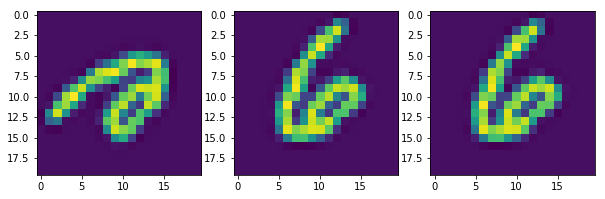

In [12]:
# Try visualize one observation of 400 (or 20x20 pixels)
# Test1,2,3 are different ways of reshaping the pixels
test1 = X[3000,:].reshape(20,20)
test2 = X[3000,:].reshape(20,20).T
test3 = X[3000,:].reshape(20,20, order='F')

fig, axes = plt.subplots(1,3, figsize=(10,5))
axes[0].imshow(test1)
axes[1].imshow(test2)
axes[2].imshow(test2)


Based on above figures, the correct way of reshaping the image is by passing __order='F'__ into __reshape()__ function arguments

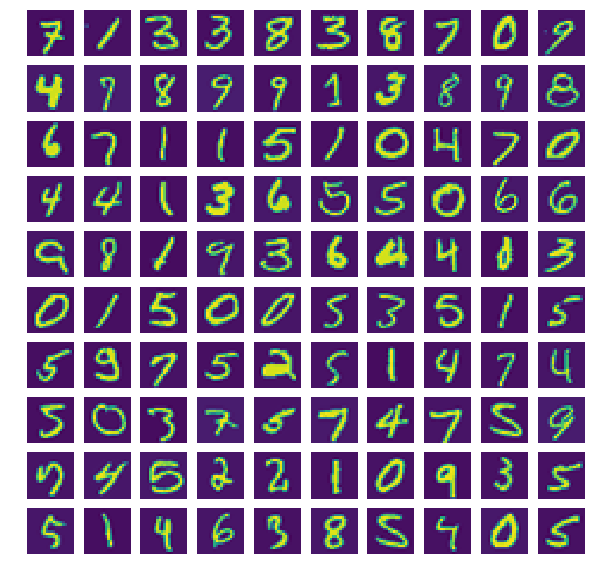

In [13]:
fig,axes = plt.subplots(10,10, figsize=(10,10))
for i in range(100):
    axes.flatten()[i].imshow(X[np.random.randint(X.shape[0]),:].reshape(20,20, order='F'))
    axes.flatten()[i].axis('off')

__Section 1.2.__ Model Representation  
Our NN has 3 layers - an input, a hidden, and an output layer. Our inputs are pixel values of digit images. Since the images are of size 20 x 20, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1).  

![NN model](./NN_model.png)

In [15]:
# Load saved thetas from ex4weights.mat
datathetas = loadmat('ex4weights.mat')
datathetas.keys()


dict_keys(['__header__', '__globals__', '__version__', 'Theta2', 'Theta1'])

In [17]:
Theta1 = datathetas['Theta1']
Theta2 = datathetas['Theta2']
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

In [27]:
# Unrolling parameters into a vector
nn_params = np.r_[Theta1.flatten(), Theta2.flatten()]
nn_params.reshape(-1,1).shape

(10285, 1)

__Section 1.3.__ Feedforward and (regularized) cost function  
- define the function, __nnCostFunction__ (regularized version), based on  **Part.1** in [MatlabTrack](https://github.com/jhonsen/machinelearn_NG/tree/master/Matlab_track)
- use lambda = 0 (applying no regularization)

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} [-y_{k}^{(i)}log((h_\theta(x^{(i)}))_k) - (1-y_k
^{(i)})log(1-(h_\theta(x^{(i)}))_k )] $$  

with y recoded into  

$$\mathbf{y} = \left[\begin{array}
{rrr}
1 \\
0 \\
0 \\
. \\
. \\
0 \\
\end{array}\right]
, 
\left[\begin{array}
{rrr}
0 \\
1 \\
0 \\
. \\
. \\
0 \\
\end{array}\right]
, ... or
\left[\begin{array}
{rrr}
0 \\
0 \\
0 \\
. \\
. \\
1 \\
\end{array}\right]
$$

- call nnCostFunction using nnparameters (containing unrolled Theta1 and Theta2).  



In [99]:
def sigmoid(v):
    out = 1.0 / (1.0 + np.exp(-v))
    return out 

In [75]:
hidden_layersize = 25
input_layersize = 400
num_labels = 10
lamd=0

def nnCostFunction(nn_params, input_layersize, hidden_layersize, num_labels, X,y,lamd):
    
    # Extract thetas from nn_params
    Theta1 = nn_params[:(hidden_layersize * (input_layersize +1))].reshape(hidden_layersize, (input_layersize+1))
    Theta2 = nn_params[((hidden_layersize * (input_layersize +1))):].reshape(num_labels, (hidden_layersize+1))
    
    # number of obsrvations
    m = X.shape[0]
              
    # Create a matrix of one-vs-ALL
    y_matrix = np.asarray(pd.get_dummies(y.ravel())) #<< 5000x10
    
    # Part1. Feed-forward NN
    a1 = np.c_[np.ones((m,1)), X]
    z2 = a1 @ Theta1.T
    gz2 = sigmoid(z2)
    a2 = np.c_[np.ones((m,1)), gz2]
    z3 = a2 @ Theta2.T
    gz3 = sigmoid(z3)
    a3 = gz3    #<<< 5000x10
    
    # Calculate Regularized cost function and gradient
    J = -1*(1/m) * np.sum( (np.log(a3) * (y_matrix) + np.log(1-a3) * (1-y_matrix)) )
    J = J + (lamd/(2*m)) * (np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:,1:])))

    return J
                                                                                                                                               

0.2876291651613189

- Try __nnCostFunction__ using lamda=0 (not regularized)

In [78]:
J = nnCostFunction(nn_params, input_layersize, hidden_layersize, num_labels, X, y, lamd)       
print('Cost at parameters (loaded from ex4weights): %f, which should be about 0.287629' %J)


Cost at parameters (loaded from ex4weights): 0.287629, which should be about 0.287629


__Section 1.4.__ Regularized cost function. 
- use lambda = 1  

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} [-y_{k}^{(i)}log((h_\theta(x^{(i)}))_k) - (1-y_k
^{(i)})log(1-(h_\theta(x^{(i)}))_k )] +$$
$$\frac{\lambda}{2m}  [ \sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j,k}^{(2)})^2  ]$$  
  
__Note__: the summation is done twice  
- rerun nnCostFunction with nnparameters(cont. Theta1 and Theta2)
  


In [80]:
lamda = 1
J = nnCostFunction(nn_params, input_layersize, hidden_layersize, num_labels, X, y, lamda)
print('Cost at parameters (loaded from ex4weights): %f, which should be about 0.38770' %J)

Cost at parameters (loaded from ex4weights): 0.383770, which should be about 0.38770


### Section 2. Backpropagation

__Section 2.1__ Sigmoid Gradient  
Implement the sigmoid gradient function $$g'(z) = \frac{d}{dz} g(z) = g(z)(1-g(z))$$
where  
$$sigmoid(z) = g(z)= \frac{1}{1 + e^{-z}} $$


In [100]:
def sigmoidGradient(z):
    out = sigmoid(z)*(1-sigmoid(z))
    return out

In [96]:
# Try function, when z=0 gradient should be 0.25
sigmoidGradient(0)

0.25

In [114]:
# Try function on a vector
g = [-1, 0.5, 0, 0.5, 1]
print('For the vector, [-1,0.5,0,0.5,1],\n  ')
print('The sigmoid gradients are', *[sigmoidGradient(each) for each in g], sep='  ')

For the vector, [-1,0.5,0,0.5,1],
  
The sigmoid gradients are  0.19661193324148185  0.2350037122015945  0.25  0.2350037122015945  0.19661193324148185


---

__Section 2.2.__ Random Initialization  
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One exective strategy for random initialization is to randomly select values for $\theta^{(l)}$ uniformly in the range $[-\epsilon_{init},\epsilon_{init}]$.   
- Use $-\epsilon_{init}=0.12$.   

This range of values ensures that the parameters are kept small and makes the learning more efficient.  

Define a function __randInitializeWeights__ to initialize weights for $\theta$



In [123]:
def randInitializeWeights(Lin, Lout):
    
    epsilon_init = 0.12
    W = np.random.random((Lout, 1+Lin)) * 2 * epsilon_init + epsilon_init
    
    return W


In [130]:
# Initialize NN_Parameters, instead of using the loaded ex4weights.mat dataset
initial_Theta1 = randInitializeWeights(input_layersize, hidden_layersize)
initial_Theta2 = randInitializeWeights(hidden_layersize, num_labels)

initial_nn_params = np.r_[initial_Theta1.flatten(), initial_Theta2.flatten()].reshape(-1,1)

__Section 2.3.__ Backpropagation  
  
  
The intuition is as follows:  
Given a training example $(x^{(t)}; y^{(t)})$, we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_{\theta}(x)$. Then, for each node $j$ in layer $l$, we would like to compute an "error term" $\delta_j^{(l)}$ that measures how much that node was "responsible" for any errors in our output.

For an output node, we can directly measure the difference between the network's activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer $(l + 1)$.

In detail, here is the backpropagation algorithm (also depicted in the figure). You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop for $t = 1:m$ and place steps 1-4 below inside the for-loop, with the tth iteration performing the calculation on the tth training example $(x(t); y(t))$. Step 5 will divide the accumulated gradients by m to obtain the gradients for the neural network cost function.  
![Backpropagation updates](./Backpropagation.jpg)  


__Section 2.4 & 2.5__ Now, implement back-propagation (__Part.2__) and regularization (__Part.3__) to the costfunction, __nnCostFunction__


$\frac{\delta}{\delta\Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}$ for J=0  
$\frac{\delta}{\delta\Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}+\frac{\lambda}{m}\Theta_{ij}^{(l)} $ for J>=1

In [195]:
def nnCostFunction(nn_params, input_layersize, hidden_layersize, num_labels, X,y,lamd):
    
    # Extract thetas from nn_params
    Theta1 = nn_params[:(hidden_layersize * (input_layersize +1))].reshape(hidden_layersize, (input_layersize+1))
    Theta2 = nn_params[((hidden_layersize * (input_layersize +1))):].reshape(num_labels, (hidden_layersize+1))
    
    # number of obsrvations
    m = X.shape[0]
              
    # Create a matrix using one-hot-encoding from pandas.get_dummies
    y_matrix = np.asarray(pd.get_dummies(y.ravel())) #<< 5000x10
    
    # Part1. Feed-forward NN
    a1 = np.c_[np.ones((m,1)), X]   #<-- 5000x401
    z2 = a1 @ Theta1.T              #<-- 5000x401 dot 401x25 = 5000x25
    gz2 = sigmoid(z2)               #<-- 5000x25 
    a2 = np.c_[np.ones((m,1)), gz2] #<-- 5000x26
    z3 = a2 @ Theta2.T              #<-- 5000x26 dot 26x10 = 5000x10  
    gz3 = sigmoid(z3)               #<-- 5000x10
    a3 = gz3    #<<< 5000x10
    
    # Calculate Regularized cost function and gradient
    J = -1*(1/m) * np.sum( (np.log(a3) * (y_matrix) + np.log(1-a3) * (1-y_matrix)) )
    J = J + (lamd/(2*m)) * (np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:,1:])))

    # -------- up until here, codes were copied from function earlier ---------------------------#
    
    # Part 2. 
    # Output layer
    d3 = a3 - y_matrix  #<-- 5000x10
    # Hidden layer
    d2 = d3 @ Theta2[:,1:]  * sigmoidGradient(z2)  #<--   5000x10 dot 10x25  times  5000x25  = 5000x25
    
    # Accumulated gradient
    Delta1 = d2.T @ a1                             #<--  25x5000 dot 5000x401 = 25x401
    Delta2 = d3.T @ a2                             #<--  10x5000 dot 5000x26 =  10x26
    
    # Obtain th gradient for the NN by dividing accumulated gradient by 1/m
    Theta1_grad = (1/m) * Delta1                   #<-- 25x401
    Theta2_grad = (1/m) * Delta2                   #<-- 10x26
    
    # Part 3. Add regularizations
    Theta1[:,0] = 0
    Theta2[:,0] = 0
    
    Theta1 = Theta1 * (lamd/m)                     #<-- 25x401 
    Theta2 = Theta2 * (lamd/m)                     #<-- 10x26
    
    Theta1_grad = Theta1_grad + Theta1
    Theta2_grad = Theta2_grad + Theta2
    
    grad = np.r_[Theta1_grad.flatten(), Theta2_grad.flatten()].reshape(-1,1)
    
    return J



Splitting Part 2 and 3 into its own function __nnGrad__

In [215]:
def nnGrad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    # Extract thetas from nn_params
    Theta1 = nn_params[:(hidden_layersize * (input_layersize +1))].reshape(hidden_layersize, (input_layersize+1))
    Theta2 = nn_params[((hidden_layersize * (input_layersize +1))):].reshape(num_labels, (hidden_layersize+1))
    
    # number of obsrvations
    m = X.shape[0]
              
    # Create a matrix using one-hot-encoding from pandas.get_dummies
    y_matrix = np.asarray(pd.get_dummies(y.ravel())) #<< 5000x10
    
    # Part1. Feed-forward NN
    a1 = np.c_[np.ones((m,1)), X]   #<-- 5000x401
    z2 = a1 @ Theta1.T              #<-- 5000x401 dot 401x25 = 5000x25
    gz2 = sigmoid(z2)               #<-- 5000x25 
    a2 = np.c_[np.ones((m,1)), gz2] #<-- 5000x26
    z3 = a2 @ Theta2.T              #<-- 5000x26 dot 26x10 = 5000x10  
    gz3 = sigmoid(z3)               #<-- 5000x10
    a3 = gz3    #<<< 5000x10
    
    # -------- up until here, codes were copied from function earlier ---------------------------#
    
    # Part 2. 
    # Output layer
    d3 = a3 - y_matrix  #<-- 5000x10
    # Hidden layer
    d2 = d3 @ Theta2[:,1:]  * sigmoidGradient(z2)  #<--   5000x10 dot 10x25  times  5000x25  = 5000x25
    
    # Accumulated gradient
    Delta1 = d2.T @ a1                             #<--  25x5000 dot 5000x401 = 25x401
    Delta2 = d3.T @ a2                             #<--  10x5000 dot 5000x26 =  10x26
    
    # Obtain th gradient for the NN by dividing accumulated gradient by 1/m
    Theta1_grad = (1/m) * Delta1                   #<-- 25x401
    Theta2_grad = (1/m) * Delta2                   #<-- 10x26
    
    # Part 3. Add regularizations
    Theta1[:,0] = 0
    Theta2[:,0] = 0
    
    Theta1 = Theta1 * (lamd/m)                     #<-- 25x401 
    Theta2 = Theta2 * (lamd/m)                     #<-- 10x26
    
    Theta1_grad = Theta1_grad + Theta1
    Theta2_grad = Theta2_grad + Theta2
    
    grad = np.r_[Theta1_grad.flatten(), Theta2_grad.flatten()].reshape(-1,1)
    
    return grad.ravel() # <--the needs to be flattened for fmin_cg to work (used in sect. 2.6)

In [216]:
J = nnCostFunction(nn_params, input_layersize, hidden_layersize, num_labels, X,y,lamd)
grad = nnGrad(nn_params, input_layersize, hidden_layersize, num_labels, X,y,lamd)

print('const function is: ',J )
print('gradients are \n', grad)


const function is:  0.6128069876824288
gradients are 
 [-4.51820903e-03 -6.33744979e-12  1.31648811e-12 ...  5.96893463e-03
  5.04300365e-03  2.03204838e-03]


- Testing function with lamda=3

In [217]:
lamd = 3

debugJgrad = nnGrad(nn_params, input_layersize, hidden_layersize, num_labels, X, y, lamd)

print('Gradients at (fixed) debugging parameters w/ lambda=3: \n', debugJgrad)

Gradients at (fixed) debugging parameters w/ lambda=3: 
 [-4.51820903e-03 -6.33744979e-12  1.31648811e-12 ...  5.96893463e-03
  5.04300365e-03  2.03204838e-03]


__Section 2.6__ Learning parameters  
After you have successfully implemented the neural network cost function and gradient computation, the next step of the script will use __fmincg__ (available in scipy.optimize) to learn a good set parameters.

In [283]:
lamd = 1
mIter = 50
Thetas_opt = opt.fmin_cg(f=nnCostFunction, 
                         x0=initial_nn_params, 
                         fprime=nnGrad,
                         args =(input_layersize, hidden_layersize, num_labels, X, y, lamd),
                         maxiter=mIter)
                    
Theta1_opt = Thetas_opt[:(hidden_layersize * (input_layersize +1))].reshape(hidden_layersize, (input_layersize+1))
Theta2_opt = Thetas_opt[((hidden_layersize * (input_layersize +1))):].reshape(num_labels, (hidden_layersize+1))
    


         Current function value: 0.562502
         Iterations: 50
         Function evaluations: 113
         Gradient evaluations: 113


In [220]:
print(Theta1_opt.shape, Theta2_opt.shape)

(25, 401) (10, 26)


### Checking the accuracy of predictions made by the trained NN
Now we'd like to use the trained NN to predict the labels. 
Use __predict.m__ function to predict the labels of the training sets and cmpute accuracy

In [221]:
# Make prediction function

def predict(theta_1, theta_2, Xorig):
    m = Xorig.shape[0]
    Xorig = np.c_[np.ones((m,1)), Xorig]   #<-- 5000x401
    
    z2 = Xorig @ theta_1.T        #<-- 5000x401 dot 401x25 = 5000x25
    
    a2 = np.c_[np.ones((m,1)), sigmoid(z2)] #<-- 5000x26
    
    z3 = a2 @ theta_2.T                     #<-- 5000x26 dot 26xX10 = 5000x10
    a3 = sigmoid(z3)                        #<-- 5000x10  

    return np.argmax(a3, axis=1)+1



In [285]:
# Predict on Training Set
pred = predict(Theta1_opt,Theta2_opt, X)
print('Using, lambda= %s, maxIter= %s' %(lamd, mIter))
print('Training Set Accuracy: %.1f%%' %(np.mean(pred == y.ravel())*100))

Using, lambda= 1, maxIter= 50
Training Set Accuracy: 93.6%


### Section 3. Visualizing Hidden Layer

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units.   
Thus, one way to visualize the \representation" captured by the hidden unit is to reshape this 400 dimensional vector into a 20x20 image anddisplay it.   
The next step will show you an image with 25 units, each corresponding to one hidden unit in the network.  


In your trained network, you should find that the _hidden units corresponds roughly to detectors that look for strokes and other patterns in the input._

	Visualizing Neural Network, Hidden Layer1
	Using lambda= 1, maxIter= 50
	Training Set Accuracy: 93.6%


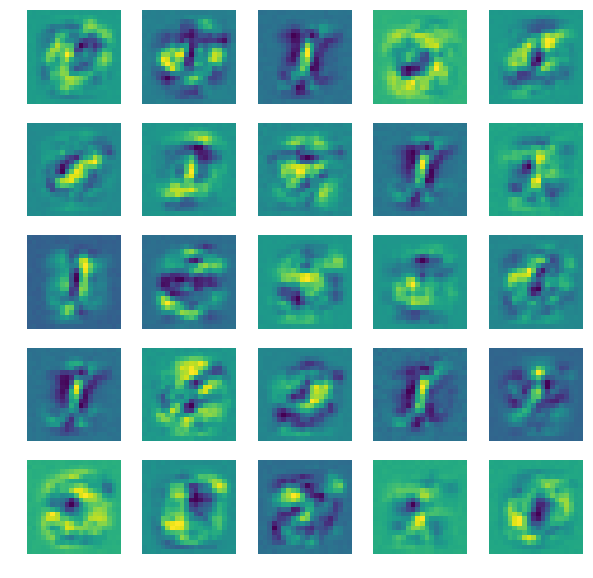

In [259]:
fig,axes = plt.subplots(5, 5, figsize=(10,10))

for i in range(Theta1_opt.shape[0]):
    axes.flatten()[i].imshow(Theta1_opt[i,1:].reshape(20,20, order='F'))
    axes.flatten()[i].axis('off')
print('\tVisualizing Neural Network, Hidden Layer1')
print('\tUsing lambda= %s, maxIter= %s' %(lamd, mIter))
print('\tTraining Set Accuracy: %.1f%%' %(np.mean(pred == y.ravel())*100))


	Visualizing Neural Network, Hidden Layer1
	Using lambda= 100, maxIter= 50
	Training Set Accuracy: 83.6%


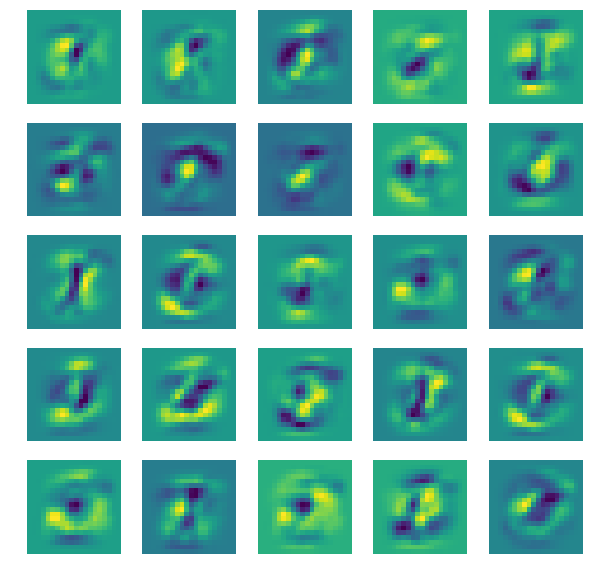

In [270]:
fig,axes = plt.subplots(5, 5, figsize=(10,10))

for i in range(Theta1_opt.shape[0]):
    axes.flatten()[i].imshow(Theta1_opt[i,1:].reshape(20,20, order='F'))
    axes.flatten()[i].axis('off')
print('\tVisualizing Neural Network, Hidden Layer1')
print('\tUsing lambda= %s, maxIter= %s' %(lamd, mIter))
print('\tTraining Set Accuracy: %.1f%%' %(np.mean(pred == y.ravel())*100))

Observation:  

- When lamda is large (more regularization), the effect of each theta becomes less apparent. The visualized thetas look somewhat diffused (or they are smoothened).
- When lamda is small (less regularization), the effect of each theta is more apparent. The visualized thetas show more details (more pixelated).

In [302]:
# Try to create a grid of accuracy, w/ respect to maxIter and Lamda values
def gridTrainingAcc(maxIter, lamda, X, y):
        
    Thetas_opt = opt.fmin_cg(f=nnCostFunction, 
                         x0=initial_nn_params, 
                         fprime=nnGrad,
                         args =(input_layersize, hidden_layersize, num_labels, X, y, lamda),
                         maxiter=maxIter)
    Theta1_opt = Thetas_opt[:(hidden_layersize * (input_layersize +1))].reshape(hidden_layersize, (input_layersize+1))
    Theta2_opt = Thetas_opt[((hidden_layersize * (input_layersize +1))):].reshape(num_labels, (hidden_layersize+1))
    
    prod = (np.mean(predict(Theta1_opt, Theta2_opt, X) == y.ravel())*100)
    
    return prod

maxIter_list = [50, 250, 500]
lamda_list = [1, 3, 5]

import itertools as it

results = []
for m,l in it.product(maxIter_list, lamda_list):
    results.append([m,l, gridTrainingAcc(m,l, X, y)])


         Current function value: 0.562502
         Iterations: 50
         Function evaluations: 113
         Gradient evaluations: 113
         Current function value: 0.754287
         Iterations: 50
         Function evaluations: 126
         Gradient evaluations: 126
         Current function value: 1.134440
         Iterations: 50
         Function evaluations: 119
         Gradient evaluations: 119
         Current function value: 0.327365
         Iterations: 250
         Function evaluations: 593
         Gradient evaluations: 593
         Current function value: 0.682405
         Iterations: 67
         Function evaluations: 229
         Gradient evaluations: 218
         Current function value: 1.086618
         Iterations: 55
         Function evaluations: 175
         Gradient evaluations: 164
         Current function value: 0.314835
         Iterations: 500
         Function evaluations: 1207
         Gradient evaluations: 1207
         Current function value: 0.682405
  

In [303]:
df =pd.DataFrame(results, columns=['maxIter','lamda','accuracy'])
df

,maxIter,lamda,accuracy
0,50,1,93.60
1,50,3,94.02
2,50,5,89.30
3,250,1,99.24
4,250,3,96.48
5,250,5,90.60
6,500,1,99.46
7,500,3,96.48
8,500,5,90.60


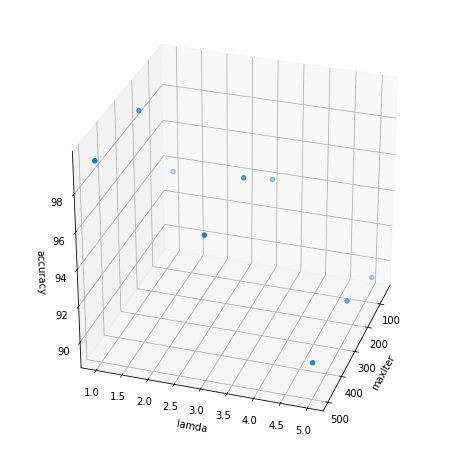

In [304]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['maxIter'], df['lamda'], df['accuracy'])
ax.view_init(30, 18)
ax.set_xlabel('maxIter')
ax.set_ylabel('lamda')
ax.set_zlabel('accuracy')
plt.show()